# Collaborative-Based Books Recommender System Using Collaborative Filter

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ingest Dataset & Preliminary Massaging

## Ingestion

In [3]:
#Note that this 
books = pd.read_csv('../books_data/books.csv', delimiter=';', on_bad_lines='skip', encoding='latin-1')
ratings = pd.read_csv('../books_data/ratings.csv', delimiter=';', on_bad_lines='skip', encoding='latin-1')
users = pd.read_csv('../books_data/users.csv', delimiter=';', on_bad_lines='skip', encoding='latin-1')

/var/folders/lx/grtnyt691053gpc4xdmv86m80000gn/T/ipykernel_3987/728942945.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('../books_data/books.csv', delimiter=';', on_bad_lines='skip', encoding='latin-1')


### Preliminary Dataframe Massaging

In [4]:
# Make all the columns lowercases and replace dashes with underscores
books.columns = [x.lower().replace('-', '_') for x in books.columns]
ratings.columns = [x.lower().replace('-', '_') for x in ratings.columns]
users.columns = [x.lower().replace('-', '_') for x in users.columns]

# Initial Exploratory Data Analysis

## Preview Books

In [5]:
books.head()

,isbn,book_title,book_author,year_of_publication,publisher,image_url_s,image_url_m,image_url_l
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [6]:
books.tail(2)

,isbn,book_title,book_author,year_of_publication,publisher,image_url_s,image_url_m,image_url_l
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...
271359,0767409752,A Guided Tour of Rene Descartes' Meditations o...,Christopher Biffle,2000,McGraw-Hill Humanities/Social Sciences/Languages,http://images.amazon.com/images/P/0767409752.0...,http://images.amazon.com/images/P/0767409752.0...,http://images.amazon.com/images/P/0767409752.0...


### Information Available
From the schema, we can see the following columns:
- isbn: Primary key for this table
- book_title: Compound Primary key for this table -> We should check to ensure that there are an equal number of unique isbn and book_titles. Otherwise, we'd see that one isbn code may map to different book_titles
- book_author
- year_of_publication
- publisher
- image_url_s
- image_url_m
- image_url_l

This is a the book dimension table. If we choose to do a content-based filtering approach, we'd use the features from this table to cluster the items

The dataframe has 3 columns that hold the image URL but for different sizes, we'll drop 2/3
TODO Drop all image_url columns but large

In [7]:
books.shape

(271360, 8)

In [8]:
len(books['isbn'].unique())

271360

From this preview, we can see:
1. there are approximately 29245 duplicate books in the dataframe that we'll need to drop
TODO Drop duplicate books

In [9]:
books = books.drop(columns=['image_url_s', 'image_url_m'])

In [10]:
books.head(2)

,isbn,book_title,book_author,year_of_publication,publisher,image_url_l
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...


## Preview ratings

In [11]:
ratings.head()

,user_id,isbn,book_rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [12]:
ratings.tail()

,user_id,isbn,book_rating
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10
1149779,276723,05162443314,8


In [13]:
ratings.shape

(1149780, 3)

### Information Available
From the schema, we can see the following columns:
- user_id: foreign key for users table
- isbn: foreign key for books table
- book_rating: The ratings given

This is clearly the fact table so it'll be important to check the missingness in both foreign key columns. This is because we'll be joining these tables later on. 

It'll also be important to understand the scale of rating



### TODO Check the average amount of ratings given per users

## Preview users

In [14]:
users.head()

,user_id,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [15]:
users.tail()

,user_id,location,age
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN
278857,278858,"dublin, n/a, ireland",NaN


### Information Available
From the schema, we can see the following columns:
- user_id: primary key for table
- location
- age

Since we are doing a collaborative filtering based approach, both the secondary features may be useful in clustering users into demographics. It'll be useful in further EDA to explore which type of books, different age_groups and locations gravitated towards




In [16]:
users.shape

(278858, 3)

In [17]:
len(users['user_id'].unique())

278858

No duplicate users

## Investigate Missingness
Further down the line, I'm going to merge all three tables into one master table. To ensure completeness, I'll investigate the missingness with the following priority:
1. Primary/Foreign Keys
2. Other Features

In [18]:
books.info()
books.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   isbn                 271360 non-null  object
 1   book_title           271360 non-null  object
 2   book_author          271358 non-null  object
 3   year_of_publication  271360 non-null  object
 4   publisher            271358 non-null  object
 5   image_url_l          271357 non-null  object
dtypes: object(6)
memory usage: 12.4+ MB


isbn                   0
book_title             0
book_author            2
year_of_publication    0
publisher              2
image_url_l            3
dtype: int64

In [19]:
ratings.info()
ratings.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   user_id      1149780 non-null  int64 
 1   isbn         1149780 non-null  object
 2   book_rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


user_id        0
isbn           0
book_rating    0
dtype: int64

In [20]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   278858 non-null  int64  
 1   location  278858 non-null  object 
 2   age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [21]:
users.isnull().sum()

user_id          0
location         0
age         110762
dtype: int64

## Findings
1. All primary/foreign keys are complete
2. The age column of the users table has a significant amount of missing data. This will be a problem when it comes to clustering users based on age. **This may suggest that a content-based filter is preferable**

## Investigate Number of Ratings per Book/Per Person

In [22]:
# This gives us the number of ratings given by a user, and a book
ratings['user_id'].value_counts().to_csv('../books_data/results/num_ratings_per_user.csv')
ratings['isbn'].value_counts().to_csv('../books_data/results/num_ratings_per_book.csv')

In [23]:
ratings_per_user = pd.read_csv('../books_data/results/num_ratings_per_user.csv')
ratings_per_book = pd.read_csv('../books_data/results/num_ratings_per_book.csv')

<Axes: >

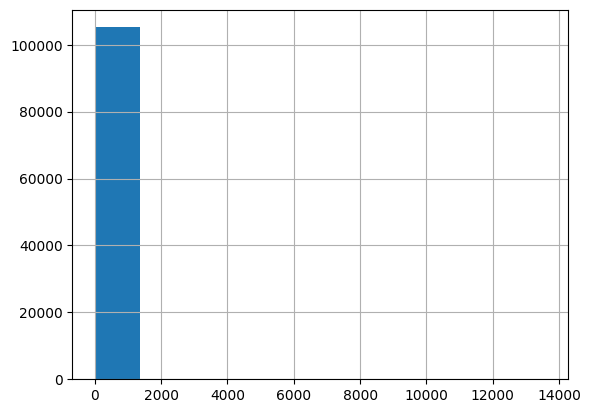

In [24]:
ratings['user_id'].value_counts().hist()

In the tutorial I'm watching, the guy filters out all users that have read less thatn 200 books, because he doesn't see it as relevant. From my understanding of collaborative filtering, users that have rated few books are still relevant because we're grouping on users. If instead we're doing item-based collaborative filtering, then I agree that the relevance drops but I still don't believe it warrants dropping all users with less than 200 ratings. So I will not do that. I'll keep the code below just in case

In [25]:
relevant_users = ratings['user_id'].value_counts() > 200
relevant_reviews = ratings[ratings['user_id'].isin(relevant_users.index)]

## Data Merging

In [25]:
master_table = ratings.merge(books, how='left', on='isbn').merge(users, how='left', on='user_id')

In [26]:
master_table.head(2)

,user_id,isbn,book_rating,book_title,book_author,year_of_publication,publisher,image_url_l,location,age
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,"tyler, texas, usa",NaN
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.0...,"seattle, washington, usa",NaN


In [27]:
master_table = master_table[['user_id', 'age', 'location' ,'book_title', 'isbn', 'book_author', 'year_of_publication', 'publisher', 'book_rating', 'image_url_l']]

In [28]:
master_table.head(2)

,user_id,age,location,book_title,isbn,book_author,year_of_publication,publisher,book_rating,image_url_l
0,276725,NaN,"tyler, texas, usa",Flesh Tones: A Novel,034545104X,M. J. Rose,2002,Ballantine Books,0,http://images.amazon.com/images/P/034545104X.0...
1,276726,NaN,"seattle, washington, usa",Rites of Passage,0155061224,Judith Rae,2001,Heinle,5,http://images.amazon.com/images/P/0155061224.0...


In [29]:
num_rating = master_table.groupby('book_title')['book_rating'].count().reset_index()

In [ ]:
# num_rating.sort_values(by=['book_rating'], ascending=False)

,book_title,book_rating
234951,Wild Animus,2502
196326,The Lovely Bones: A Novel,1295
183573,The Da Vinci Code,898
5303,A Painted House,838
199237,The Nanny Diaries: A Novel,828
...,...,...
147559,Real Love: The Truth About Finding Uncondition...,1
147558,Real Love: The Drawings for Sean,1
147557,"Real Love or Fake (Camfield Novel of Love, No 78)",1
63664,Fabulous Food for Family and Friends: Healthy ...,1


: 

## Create Pivot Table

In [ ]:
book_pivot = master_table.pivot_table(columns='user_id', index='book_title', values='book_rating')

/var/folders/lx/grtnyt691053gpc4xdmv86m80000gn/T/ipykernel_3976/831077258.py:1: PerformanceWarning: The following operation may generate 22204085526 cells in the resulting pandas object.
  book_pivot = master_table.pivot_table(columns='user_id', index='book_title', values='book_rating')
